# Amazon Customer Sentiment Analysis- Python Code

### Importing required libraries

In [1]:
# Data manipulation
import json
import csv
import sqlite3
import pandas as pd
import numpy as np

# Natural Language Processing
import nltk
from nltk.stem.porter import PorterStemmer
import string
import re
from wordcloud import WordCloud, STOPWORDS

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Machine Learning
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


### Reading json data file

In [2]:
luxury_beauty_data = pd.read_json('Luxury_Beauty_5.json', lines=True)

In [3]:
luxury_beauty_data

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
34273,4,False,"09 3, 2017",A2CF66KIQ3RKX3,B01GOZ61O8,NaN,Vivian Deliz,I like to use moisturizers and sunscreens that...,Works great as a moisturizer and sunscreen,1504396800,NaN,NaN
34274,4,False,"09 3, 2017",A1LKOIZXPQ9VG0,B01GOZ61O8,NaN,Elisa 20,I wouldn't be able to afford this if not asked...,Nice skin care product and sunscreen if you do...,1504396800,NaN,NaN
34275,1,True,"08 25, 2017",AV2RWORXTFRJU,B01H353HUY,NaN,Gapeachmama,Did nothing,One Star,1503619200,NaN,NaN
34276,5,False,"07 8, 2017",A22S7D0LP8GRDH,B01H353HUY,NaN,Jacob and Kiki Hantla,I love the Oribe bright blonde radiance spray....,No more brass!,1499472000,NaN,NaN


### Count  of reviews by rating

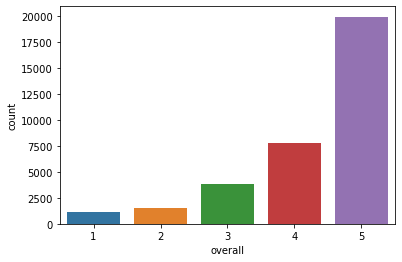

In [4]:
sns.countplot(x='overall', data=luxury_beauty_data)
plt.show()

### Converting json file to csv

In [5]:
luxury_beauty_data.to_csv('lb_data.csv', sep=',', header=False,index=False)

### Loading csv data file in SQLite

In [6]:
class CsvReader:
    def __init__(self, filename):
        self.filename = filename

    def read_csv(self):
        conn = sqlite3.connect('amazon_data.db')
        cur = conn.cursor() 

        cur.execute("""CREATE TABLE IF NOT EXISTS luxury_beauty_data(
                        overall INT,
                        verified INT,
                        reviewTime varchar,
                        reviewerID INT,
                        asin varchar,
                        style varchar,
                        reviewerName varchar,
                        reviewText varchar,
                        summary varchar,
                        unixReviewTime INT,
                        vote INT,
                        image INT)""")
        
        print("luxury_beauty_data table created.")

        with open(self.filename, encoding='utf-8') as f:
            reader = csv.reader(f)
            for row in reader:
                cur.execute("INSERT INTO luxury_beauty_data VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);", row)

        print(f"{self.filename} loaded into luxury_beauty_data table in SQLite.")

        conn.commit()
        conn.close()

filename = 'lb_data.csv'
csv_reader = CsvReader(filename)
csv_reader.read_csv()


luxury_beauty_data table created.
lb_data.csv loaded into luxury_beauty_data table in SQLite.


### Selecting all data

In [7]:
Amazon_data = sqlite3.connect('amazon_data.db')

pd.read_sql_query("SELECT * FROM luxury_beauty_data LIMIT 5", Amazon_data)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,,
1,5,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,,
2,5,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,,
3,5,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,,
4,5,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,,


### Selecting required data 

In [8]:
required_data = pd.read_sql_query("""
SELECT 
  overall,
  reviewText,
  summary
FROM luxury_beauty_data 
WHERE overall != 3""", Amazon_data)

In [9]:
required_data.head(5)

,overall,reviewText,summary
0,5,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance
1,5,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion
2,5,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around
3,5,Thanks!!,Five Stars
4,5,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!


### Creating new coloumn by filtering reviews

In [10]:
required_data["sentiment"] = required_data["overall"].apply(lambda score: "positive" if score > 3 else "negative")

In [11]:
required_data.head(5)

,overall,reviewText,summary,sentiment
0,5,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,positive
1,5,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,positive
2,5,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,positive
3,5,Thanks!!,Five Stars,positive
4,5,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,positive


### Comparing count of positive and negative reviews

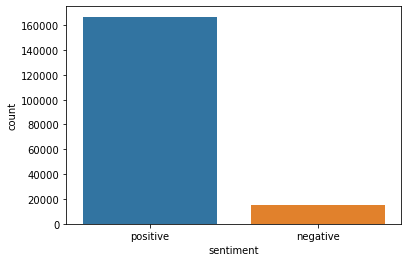

In [12]:
sns.countplot(x='sentiment', data=required_data)
plt.show()

In [13]:
required_data[required_data.overall == 5].head(5)

,overall,reviewText,summary,sentiment
0,5,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,positive
1,5,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,positive
2,5,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,positive
3,5,Thanks!!,Five Stars,positive
4,5,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,positive


In [14]:
required_data[required_data.overall == 1].head(5)

,overall,reviewText,summary,sentiment
49,1,"I have a multitude of ""designer deodorants"" an...",That burning sensation...,negative
64,1,I would give this zero stars. Formula is very ...,Very disappointed for an OPI product,negative
70,1,its ok,One Star,negative
75,1,It chip My wife nails in a day. If you have a ...,Chip My Wife Nails,negative
101,1,"This review is for Russian Navy. Nice color, b...",Beware after removal-Russian Navy,negative


### Text pre-processing

In [15]:
regex = re.compile('[^a-z]+')

def clean_reviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regex.sub(' ', reviewText).strip()
    return reviewText

required_data["summary_clean"] = required_data["summary"].apply(clean_reviews)



In [16]:
required_data.head()

,overall,reviewText,summary,sentiment,summary_clean
0,5,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,positive,beautiful fragrance
1,5,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,positive,wonderful hand lotion
2,5,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,positive,best hand cream around
3,5,Thanks!!,Five Stars,positive,five stars
4,5,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,positive,great hand lotion


### Splitting Data into train and test

In [17]:
train, test = train_test_split(required_data, test_size=0.2)
print(f"{len(train)} items in training data, {len(test)} in test data")

145891 items in training data, 36473 in test data


### Count Vectorization

In [18]:
count_vectorizer = CountVectorizer(min_df=1, ngram_range=(1, 4))
counts_X_train = count_vectorizer.fit_transform(train["summary_clean"])

# Applying tf-idf to term frequency
transformer_tfidf = TfidfTransformer()
tfidf_X_train = transformer_tfidf.fit_transform(counts_X_train)

counts_X_test = count_vectorizer.transform(test["summary_clean"])
tfidf_X_test = transformer_tfidf.transform(counts_X_test)

y_train = train["sentiment"]
y_test = test["sentiment"]

predictions = {}


### Wordcloud of All, Negative and Positive words

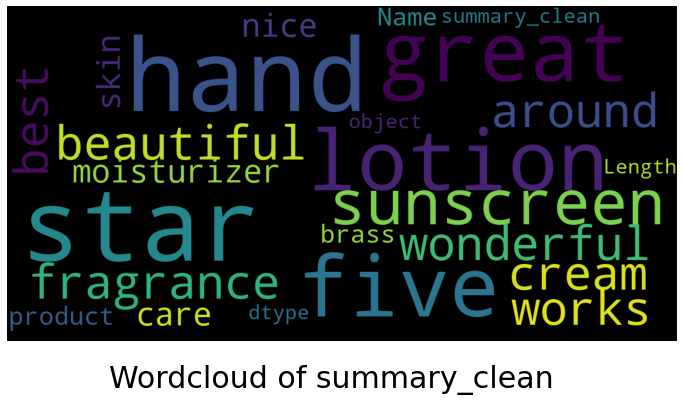

In [19]:
stopwords = set(STOPWORDS).union({'said', 'also', 'one', 'two', 'new'})

mpl.rcParams['font.size']=14                 
mpl.rcParams['savefig.dpi']=100            
mpl.rcParams['figure.subplot.bottom']=.1 

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=60, 
        scale=3,
        random_state=1
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=30)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
show_wordcloud(required_data["summary_clean"], title = "Wordcloud of summary_clean")


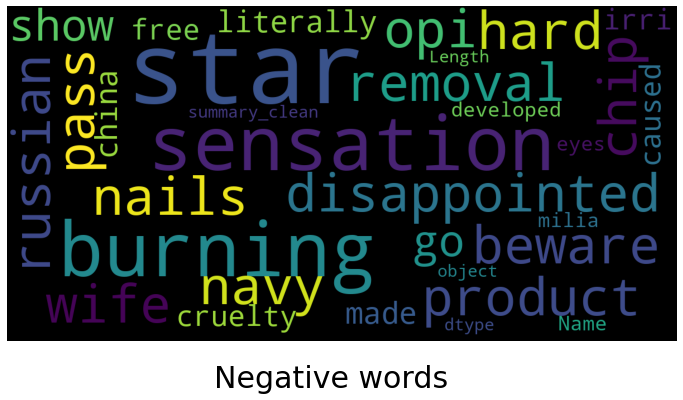

In [20]:
show_wordcloud(required_data[required_data.overall == 1]["summary_clean"], title = "Negative words")

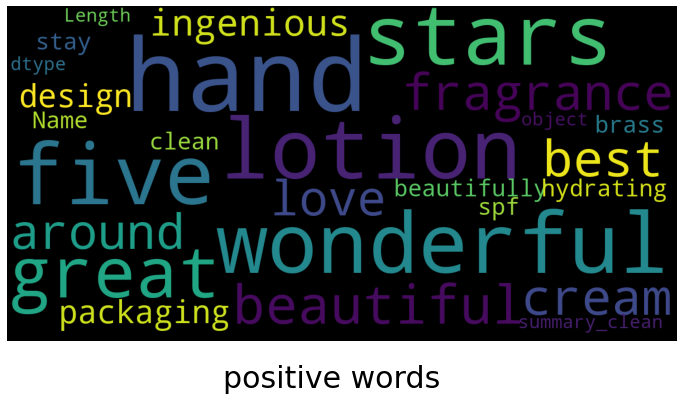

In [21]:
show_wordcloud(required_data[required_data.overall == 5]["summary_clean"], title = "positive words")

## Machine Learning Models- Multinomial Naive Bayes, Bernoulli Naive Bayes, Logistic Regression

In [22]:
mlNBmodel = MultinomialNB().fit(tfidf_X_train, y_train)
predictions['Multinomial'] = mlNBmodel.predict(tfidf_X_test)

In [23]:
brNBmodel = BernoulliNB().fit(tfidf_X_train, y_train)
predictions['Bernoulli'] = brNBmodel.predict(tfidf_X_test)

In [24]:
logreg = LogisticRegression(C=1e5).fit(tfidf_X_train, y_train)
predictions['Logistic'] = logreg.predict(tfidf_X_test)

C:\Users\pargat\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Models comparison with ROC

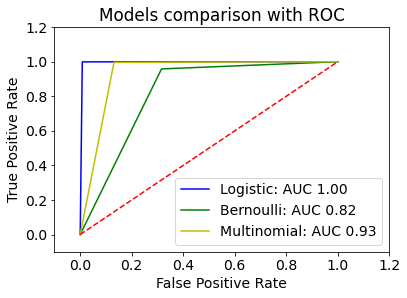

In [25]:
def format_label(label):
    return 0 if label == 'negative' else 1

vfunc = np.vectorize(format_label)

models = {'Logistic': logreg, 'Bernoulli': brNBmodel, 'Multinomial': mlNBmodel}

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model_name, model in models.items():
    y_pred = model.predict(tfidf_X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(vfunc(y_test), vfunc(y_pred))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model_name,roc_auc))
    cmp += 1

plt.title('Models comparison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Bernoulli Naive Bayes Model

In [26]:
print(metrics.classification_report(y_test, predictions['Bernoulli'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.60      0.68      0.64      3103
    negative       0.97      0.96      0.96     33370

    accuracy                           0.94     36473
   macro avg       0.79      0.82      0.80     36473
weighted avg       0.94      0.94      0.94     36473



In [27]:
accuracy_score(y_test, predictions['Bernoulli'])

0.9350204260685987

### Multinomial Naive Bayes Model

In [28]:
print(metrics.classification_report(y_test, predictions['Multinomial'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.96      0.87      0.91      3103
    negative       0.99      1.00      0.99     33370

    accuracy                           0.99     36473
   macro avg       0.97      0.93      0.95     36473
weighted avg       0.99      0.99      0.99     36473



In [29]:
accuracy_score(y_test, predictions['Multinomial'])

0.9856880432100458

### Logistic Regression Model

In [30]:
print(metrics.classification_report(y_test, predictions['Logistic'], target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.99      0.99      0.99      3103
    negative       1.00      1.00      1.00     33370

    accuracy                           1.00     36473
   macro avg       1.00      1.00      1.00     36473
weighted avg       1.00      1.00      1.00     36473



In [31]:
accuracy_score(y_test, predictions['Logistic'])

0.99854687028761

### Confusion Matrix for final Model (Logistic Regression)

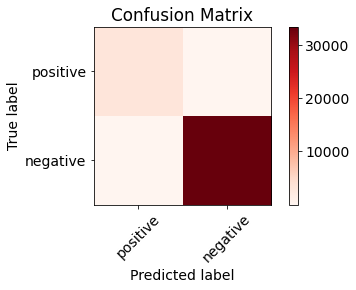

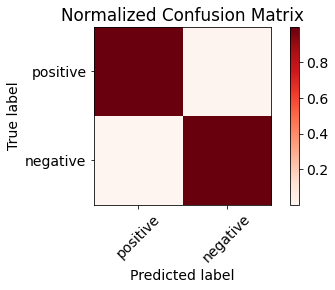

In [32]:
def plot_confusion_matrix(matrix, title='Confusion Matrix', cmap=plt.cm.Reds, label=["positive", "negative"]):
    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tickMark = np.arange(len(label))
    plt.xticks(tickMark, label, rotation=45)
    plt.yticks(tickMark, label)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix for Logistic Regression model
logreg_matrix = confusion_matrix(y_test, predictions['Logistic'])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(logreg_matrix)

# Plot normalized confusion matrix
logreg_matrix_normalized = logreg_matrix.astype('float') / logreg_matrix.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(logreg_matrix_normalized, title='Normalized Confusion Matrix')

plt.show()

### Checking our model performance by External Data

In [33]:
def testOriginal(finalModel, realData):
    test_Count = count_vectorizer.transform([realData])
    test_Tfidf = transformer_tfidf.transform(test_Count)
    result = finalModel.predict(test_Tfidf)[0]
    rProbability = finalModel.predict_proba(test_Tfidf)[0]
    print("Review is %s: negative probability %f, positive probability %f" % (result.upper(), rProbability[0], rProbability[1]))

testOriginal(logreg, "Excellent product")
testOriginal(logreg, "Not what I ordered last time")
testOriginal(logreg, "not the same as my others")

Review is POSITIVE: negative probability 0.000000, positive probability 1.000000
Review is NEGATIVE: negative probability 0.999998, positive probability 0.000002
Review is NEGATIVE: negative probability 1.000000, positive probability 0.000000
